The class for loading the knapsack dataset file 

In [7]:
import pandas as pd
import numpy as np
from copy import deepcopy
from distutils.command.build_scripts import first_line_re
from tkinter.tix import COLUMN
# Import deque for the stack structure, copy for deep copy nodes
from collections import deque

class Knapsack:
    '''For each instance, we have following fields: 
            the 1st line of the  file contains the number of items N and the knapsack capacity C.,
            2nd onwards contains the Value and Weight of each item, separated by a space.
    '''
    # main constructor 
    def __init__(self, M, capacity, items, name):
        '''M is the number of items, i.e. len(items)'''
        self.M = M
        self.name = name # name of the instance, e.g. 10_269
        self.capacity = capacity
        self.items = items
        self.items_dict  = {}
        i = 0
        for x in self.items.to_records(index=False):
            self.items_dict[i] = tuple(x)
            i += 1
        
    @classmethod
    def constructFromFile(cls, filePath):
        '''Read from file and construct an instance of Knapsack'''
        with open(filePath, 'r') as file:
            first_line = file.readline()
            M,Q_capacity = int(first_line.split(' ')[0]),int(first_line.split(' ')[1])
            # first_line = first_line.split(' ')
        itemsdf = pd.read_csv(filePath,delim_whitespace=True, skiprows=range(1), header=None)
        itemsdf.columns = ['Value', 'Weight']
        
        # add a index column for the items
        # items.index = items.index + 1
        return cls(M, Q_capacity, itemsdf, name = filePath.split('/')[-1])
    
    def __str__(self):
        return 'M = {}, capacity = {}, \nitems =\n {}'.format(self.M, self.capacity, self.items)   
ds_10_269 = Knapsack.constructFromFile('10_269')
print(ds_10_269)
len(ds_10_269.items)
# ds_10_269.items_dict[0][1]

M = 10, capacity = 269, 
items =
    Value  Weight
0     55      95
1     10       4
2     47      60
3      5      32
4      4      23
5     50      72
6      8      80
7     61      62
8     85      65
9     87      46


10

Define some hyper parameters for the Estimation of Distribution Algorthim (EDA)

In [8]:

# define some constants for the genetic algorithm
POPULATION_SIZE = 500
MAX_GENERATIONS = 60
ELITISM_PROPORTION = int(POPULATION_SIZE * 0.10)
M = int(POPULATION_SIZE * 0.25) # selected M best individuals for calculating their probability distribution 

Define the Individual Presentation 


In [9]:
class Individual_EDA:
    """Individual representation for the Estimation of Distribution Algorithms"""
    def __init__(self, chromosome, ds:Knapsack):
        self.chromosome = chromosome
        self.ds = ds
        self.fitness = self.get_fitness(ds)
        
        
    def get_fitness(self, ds: Knapsack ) -> float:
        """Calculate the fitness of an individual based on the given knapsack dataset 
        It is directly from the project 1 except the penalty term is set as a very large number which means the infeasible solution will be penalized heavily
        
        Returns: the fitness value of the current  individual
        """
        value, weight = 0.0, 0.0
        # calculate the value and weight of selected items for the given individual
        for i, item in enumerate(self.chromosome):
            value += ds.items_dict[i][0]*item # value is 0, weight is  1
            weight += ds.items_dict[i][1]*item 
        penalty = 1000 * max(0, weight - ds.capacity)
        self.fitness = value-penalty
        return self.fitness

    @staticmethod
    def sort_population(population) -> list:
        """Sort the population based on the fitness value of each individual
        Higher fitness value means better solution, so we sort in descending order

        Returns: the sorted population
        """
        return sorted(population, key=lambda x: x.get_fitness(x.ds), reverse=True) 
    
    @staticmethod
    def elitism_selection(population, k) -> list:
        """Select the top k individuals from the population
        Args:
            population: the population to be selected
            k: the number of individuals to be selected

        Returns: the selected individuals
        """
        sorted_population = Individual_EDA.sort_population(population)

        return sorted_population[0:k] # return the top k individuals
    
    @classmethod
    def get_a_random_individual(cls, ds:Knapsack):
        """Generate a random individual with the given length
        Args:
            length: the length of the individual

        Returns: a random individual
        """
        chromosome = [np.random.randint(0, 2) for _ in range(ds.M)]
        
        return cls(chromosome, ds)
    
    @staticmethod
    def get_probability_distribution(population:list, ds:Knapsack) -> list:
        """Calculate the probability distribution of the population
        Args:
            population: the population of Individual_EDA to be calculated

        Returns: the probability distribution
        """
        prob_list = []
        for i in range(ds.M): # each item got their own prob distribution
            total_i_count = sum([ind.chromosome[i] for ind in population])
            # print(total_i_count)
            prob_i = total_i_count / len(population)
            # prob_i = total_i_count / M # only consider the top M individuals
            assert len(population) == M
            prob_list.append(prob_i)
        return prob_list
    
    @staticmethod
    def evolve_population(ds:Knapsack, 
                          prob_distribution_list:list,
                          returned_evolved_pop_size:int) -> list:
        """Evolve the population based on the probability distribution

        Returns: the evolved population
        """
        evolved_population = []
        for _ in range(returned_evolved_pop_size):
            chromosome = []
            for prob in prob_distribution_list:
                chromosome.append(np.random.choice([0, 1], p=[1-prob, prob]))
            evolved_population.append(Individual_EDA(chromosome, ds))
        return evolved_population

In [10]:
from matplotlib import pyplot as plt


def EDA(ds:Knapsack, max_generations=MAX_GENERATIONS, population_size=POPULATION_SIZE, elitism_proportion=ELITISM_PROPORTION, M=M):
    """Estimation of Distribution Algorithms
    Args:
        ds: the given dataset
        max_generations: the maximum number of generations
        population_size: the size of the population
        elitism_proportion: the proportion of the population to be selected by elitism selection
        M: the number of individuals to be considered in the probability distribution

    Returns: the best individual in the final population
    """
    population = [Individual_EDA.get_a_random_individual(ds) for _ in range(population_size)]
    population = Individual_EDA.sort_population(population)

    # for storing the mean and std of the fitness value of each generation
    stats = {'mean': [], 'std': [], 'best': population[0]}
    
    for _ in range(max_generations):
        # get the top M individuals
        selected_M_individuals = Individual_EDA.elitism_selection(population, M)
        # get the probability distribution of the top M individuals
        selected_M_prob_distribution = Individual_EDA.get_probability_distribution(selected_M_individuals, ds)
        
        # then, evolve the population based on the elitist probability distribution
        elitisit_population = Individual_EDA.elitism_selection(population, elitism_proportion)
        evolved_population = Individual_EDA.evolve_population(ds, selected_M_prob_distribution, population_size-elitism_proportion)
        
        # combine the evolved population and the elitist population
        population = elitisit_population + evolved_population
        
        # sort the population
        population = Individual_EDA.sort_population(population)
        
        stats['mean'].append(np.mean([ind.get_fitness(ds) for ind in population]))
        stats['std'].append(np.std([ind.get_fitness(ds) for ind in population]))
        stats['best'] = population[0] 
    return stats


In [11]:
import random


def run_EDA(ds:Knapsack, n=5):
    """Run the EDA algorithm for n times
    Args:
        ds: the given dataset
        n: the number of times to run the algorithm
    """
    
    print("-"*50)
    print(f"Dataset : {ds.name}")
    stats_list = []
    for i in range(n):
        np.random.seed(i)
        random.seed(i)
        print(f'Running the algorithm for the {i}th time, seed = {i}')
        
        stats = EDA(ds)
        stats_list.append(stats)
        
        print(f"Best fitness value for seed {i} : {stats['best'].get_fitness(ds)}")
        # print(f"Final gen, mean value:{stats['mean'][-1]}")
        # print(f"Final gen, std  value:{stats['std'][-1]}")
        
        print("-"*10)
        
    print("-"*20)
    print(f"Mean and Std of my EDA in the {ds.name} dataset in the {n} runs: \
          \n\tMean : {np.mean([stat['best'].get_fitness(ds) for stat in stats_list])}, \
          \n\tStd : {np.std([stat['best'].get_fitness(ds) for stat in stats_list])}")
    print(f"\tBest fitness value: {max([stat['best'].get_fitness(ds) for stat in stats_list])}")
    
    
    # plot the mean and std of the fitness value of each generation for all runs
    for i in range(n):
        plt.plot(range(MAX_GENERATIONS), stats_list[i]['mean'], label=f"Seed {i} Mean")
    
    plt.title(f'{ds.name}:\nConvergence curve of the mean fitness value for all {n} runs')
    plt.xlabel('Generation')
    plt.ylabel('Mean Fitness value ')
    plt.legend(bbox_to_anchor =(1.3,-0.1), loc='lower center')
    plt.show()
    

--------------------------------------------------
Dataset : 10_269
Running the algorithm for the 0th time, seed = 0
Best fitness value for seed 0 : 295.0
----------
Running the algorithm for the 1th time, seed = 1
Best fitness value for seed 1 : 295.0
----------
Running the algorithm for the 2th time, seed = 2
Best fitness value for seed 2 : 295.0
----------
Running the algorithm for the 3th time, seed = 3
Best fitness value for seed 3 : 295.0
----------
Running the algorithm for the 4th time, seed = 4
Best fitness value for seed 4 : 295.0
----------
--------------------
Mean and Std of my EDA in the 10_269 dataset in the 5 runs:           
	Mean : 295.0,           
	Std : 0.0
	Best fitness value: 295.0


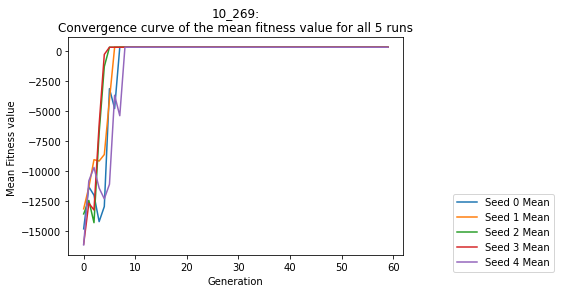

--------------------------------------------------
Dataset : 23_10000
Running the algorithm for the 0th time, seed = 0
Best fitness value for seed 0 : 9767.0
----------
Running the algorithm for the 1th time, seed = 1
Best fitness value for seed 1 : 9767.0
----------
Running the algorithm for the 2th time, seed = 2
Best fitness value for seed 2 : 9767.0
----------
Running the algorithm for the 3th time, seed = 3
Best fitness value for seed 3 : 9767.0
----------
Running the algorithm for the 4th time, seed = 4
Best fitness value for seed 4 : 9767.0
----------
--------------------
Mean and Std of my EDA in the 23_10000 dataset in the 5 runs:           
	Mean : 9767.0,           
	Std : 0.0
	Best fitness value: 9767.0


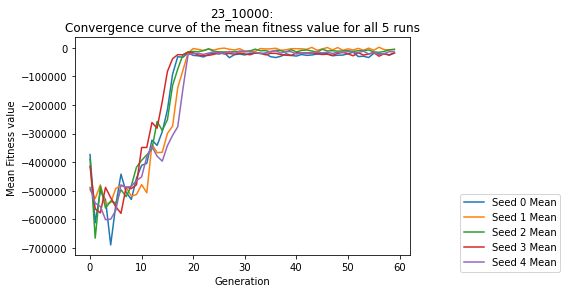

--------------------------------------------------
Dataset : 100_995
Running the algorithm for the 0th time, seed = 0
Best fitness value for seed 0 : 1514.0
----------
Running the algorithm for the 1th time, seed = 1
Best fitness value for seed 1 : 1514.0
----------
Running the algorithm for the 2th time, seed = 2
Best fitness value for seed 2 : 1514.0
----------
Running the algorithm for the 3th time, seed = 3
Best fitness value for seed 3 : 1514.0
----------
Running the algorithm for the 4th time, seed = 4
Best fitness value for seed 4 : 1514.0
----------
--------------------
Mean and Std of my EDA in the 100_995 dataset in the 5 runs:           
	Mean : 1514.0,           
	Std : 0.0
	Best fitness value: 1514.0


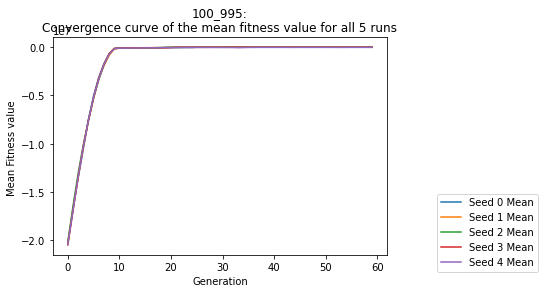

In [12]:
DATASET_PATH = ["10_269", "23_10000", "100_995"]

if __name__ == '__main__':
    for datasetPath in DATASET_PATH:
        ds = Knapsack.constructFromFile(datasetPath)
        run_EDA(ds, n = 5)
    # ds = Knapsack.constructFromFile("100_995")
    # run_EDA(ds, n = 5)
    